In [1]:
import numpy as np                                      #import numpy library
import pandas as pd                                     #import panda library
import os                                               #import OS related function library
import alpaca_trade_api as trade_api                    #import Alpaca library
import yfinance as yf                                   #import YAHOO finance API
from MCForecastTools import MCSimulation                #import Monta Carlos simulation api
from datetime import date                               #import datatime function library
from dotenv import load_dotenv                          #import .env library
from ipywidgets import *                                #import all Widgets library
from itertools import combinations                      #import combination library from itertools
import matplotlib.pyplot as plt                         #import matplotlib library
import matplotlib.gridspec as gridspec                  #import gridspec from matplotlib

import warnings                                         #import warning messages library
warnings.filterwarnings("ignore")                       #Subpress warning messages

import panel as pn                                      #import panel function library
pn.extension()                                          #Load panel extensions

pd.set_option("display.max_columns", 32)


Bad key savefig.frameon in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probab

In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [3]:
#Set up the alpaca trading API to retrieve data
def setting_api():
    alpaca_api_key=os.getenv("ALPACA_API_KEY")                                    #Set the Alpaca Key
    alpaca_secret_key=os.getenv("ALPACA_SECRET_KEY")                              #Set the Alpaca secret key
    alpaca = trade_api.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')  #Set the REST api with URL and keys
    return alpaca                                                                 #Return the Alpaca API object


#Function for retrieving data relative to tickers/portfolio
def get_portfolio_data(tickers):
    today = date.today() + pd.DateOffset(years=-5)                                #Set Start date 5 years back from now                    
    today = pd.Timestamp(today, tz="America/New_York").isoformat()                #convert to ISO datetime format
    timeframe ='1Day'                                                             #Set to retrive day trade data
    portfolio =alpaca.get_bars(tickers,timeframe,start=today,adjustment='raw').df #Get the trading info based on the ticker
    portfolio.index = portfolio.index.date                                        #Set index key to date column 
    return portfolio                                                              #Return the extracted value


#function for retrieving data related to benchmark:
def bench_mark(symbol):
    bench_mark = get_portfolio_data(symbol)                                       #Get benchmark data from Alpaca API for giventicker
    symbol = bench_mark[['close']].rename(columns = {'close': symbol})            #Rename column from 'close' to ticker name
    return symbol                                                                 #Return the extracted value

# #function to calculate risk for portfolio :
def riskf_r():
    today = date.today() + pd.DateOffset(years=-5)
    rf_rate = yf.download('^IRX',start = today)
    rf_rate = rf_rate[['Close']]
    rf_rate = rf_rate.rename(columns = {'Close' : 'rf_rate'})
    rf_returns = rf_rate.pct_change()
    rf_returns = rf_returns.dropna()
    return rf_returns


#function to seperate the required data :
def format_data(symbol):
    ticker =portfolio[portfolio["symbol"]==symbol].drop("symbol", axis=1)         #Extract ticker based on given symbol value
    closing_price = ticker[['close']]                                             #Extract close price only for that ticker
    closing_price = closing_price.rename(columns={'close' : symbol})              #Rename the column to "close"
    return closing_price                                                          #Return the extracted value


#function for calculating cuumulative returns:
def cumulative_returns(data):
    data_returns = data.pct_change()                                             #Calculate % change for given df - data
    data_cumulative = (1 + data_returns).cumprod()                               #compute the cumulative product on %change
    return data_cumulative                                                       #Return the extracted value

# function for equally weghting stocks:
def equal_weights(data):
    weights = []                                                                 #Set list variable -> weights
    for i in range(0, len(data.columns)):                                        #Cal weights for each element in -> data
        w = 1 / len(data.columns)
        weights.append(w)                                                        #Append calculated value to weights list
    return weights                                                               #Return the composed list

# function for varrying weights:
def combination_weights(data,initial_investment):
    df = []                                                                      #Init variables
    possible_combinations = []                                                   #Init variables
    a = list(np.arange(0.05,1,0.01))                                             #Get random numbers
    random_set = [round(i,3) for i in a]                                         #Round to 3 position 
    
    comb = combinations(random_set,len(data.columns))                            #Get the combination based on the random_set, with weight=data.columns
    # for loop for appropriate weights : 
#     for i in comb:
#         if sum(i) == 1:
#             possible_combinations.append(i)
    possible_combinations = [i for i in comb if sum(i) == 1]                     #Extract combination where sum(i) == 1
    daily_returns = data.pct_change().dropna()                                   #Cal pcentage change and drop any NAs
    for i in possible_combinations:                                              #Cal weighted cumulative values based on selected combination
        possible_returns = daily_returns.dot(i)
        cumulative_final_return = (1 + possible_returns).cumprod()
        final_day_value = cumulative_final_return.iloc[-1]
        final_return = final_day_value*initial_investment
        df.append((final_return,i))
    data_frame = pd.DataFrame(df)                                                #convert df to DataFrame  
    best_combination = data_frame.rename(columns={0:'Return',1:'Weights'})       #Rename column
    top_5 = best_combination.nlargest(5,'Return')                                #Get the top 5 largest values from cal df -> best_combination
    return top_5


# function for sharpe ratios :
def sharpe_ratios(data):
    #global best_weights
    
    best_weights = data['Weights']                                               #Extract 'Weights' column from data
    cumulative_weighted_portfolios = []                                          #init var cumulative_weighted_portfolios
    for i in best_weights:                                                       #Cal cumulative weighted portfolios
        weighted_price_action = portfolio_cumulative.dot(i)                      
        cumulative_weighted_portfolios.append(weighted_price_action)
        c_w_p = pd.DataFrame(cumulative_weighted_portfolios)
    c_w_p = c_w_p.T
    c_w_p = c_w_p.rename(columns ={0 :'w1',1:'w2',2:'w3',3:'w4',4:'w5'})         #Rename columns
    c_w_returns = c_w_p.pct_change()                                             #Cal percentage changes
    c_w_r =c_w_returns.dropna()                                                  #Drop any NAs
    assembled_returns = pd.concat([c_w_r,r_rate],axis =1 ,join ='inner')         #Conat dfs
    s_r = ((assembled_returns.mean()-assembled_returns['rf_rate'].mean())*252)/(assembled_returns.std()*np.sqrt(252))
    s_r = pd.Series(s_r)                                                         #Convert to series obj
    s_r = s_r.drop('rf_rate')                                                    #Drop any NAs
    s_ratio = data
    s_ratio['sharpe_ratio'] = s_r.values                                         #Add 'sharpe_ratio' column and assign the calculated value
    return s_ratio                                                               #Return the calue


def benchmark_comaprison(data, i_investment):
    spy_returns = spy.pct_change()                                               #Cal pecentage change on SPY return
    spy_returns = spy_returns.dropna()                                           #Remove any NAs
    spy_final_value = spy_cumulative * i_investment                              #Calculate SPY cumulative * initial investment
    spy_final_value=list(spy_final_value.iloc[-1])                               #Extract last value
    spy_sharpe = pd.concat([spy_returns,r_rate],axis = 1,join ='inner')          #Conta spy_returns & r_rate
    spy_sharpe_ratio = ((spy_sharpe.mean()-spy_sharpe['rf_rate'].mean()))*252/(spy_sharpe.std()*np.sqrt(252)) #Calculate shapr ration
    spy_sharpe_ratio = pd.Series(spy_sharpe_ratio)                               #Convert to series obj
    spy_sharpe_ratio = spy_sharpe_ratio['SPY']                                   #Extract SPY column
    data1 = data
    data1.loc['SPY'] = [spy_final_value[0], ((1)), spy_sharpe_ratio]
    percent_return = []                                                          #Init series obj
    for i in data1['Return']:                                                    #Calculate percent return
        per_return = ((i - i_investment)/i_investment)*100
        percent_return.append(per_return)
    #benchmark_comp = data1
    data1['%_return'] = percent_return                                           #Add '%_return' column and assign the calculated value
    return data1


#Run the MC Simulation
def MC_simulation(Years):
    global simulation_ew                                                        #Set global variable
    text = ""
    if Years > 0:
        simulation_ew = MCSimulation(                                           #run the MC simulation
                MC_data,
                weights=equal_weights(MC_data),
                num_simulation=1000,
                num_trading_days=252*Years)
        simulation_ew.calc_cumulative_return()                                  #Calculate the cumulative return
        summary_stats = simulation_ew.summarize_cumulative_return()             #summary statistics from the MC simulation results
        volatility = round(summary_stats[2] * np.sqrt(252) )                    #Calculate the volatility       
        text = f"<b>Volatility based on this configuration is {volatility}</b>" #Form the volatility information
        display(HTML(text))                                                     #Display the volatility
        display(simulation_ew.simulated_return)                                 #Display each cumulative return
        display(simulation_ew.plot_simulation())                                #Plot the simulation


        
#calculating confidenace level based on MC simulation
def confidence_level(Investment):
    """
    MC Simulation must be ran before executing this function
    """
    #global summary_stats
    Investment = Investment.replace('$','')                                     #Remove $
    Investment = Investment.replace(',','')                                     #Remove ','
    Investment = int(Investment)                                                #Convert the value to int
    summary_stats = simulation_ew.summarize_cumulative_return()                 # summary statistics from the MC simulation results
    initial_investment = Investment                                             # Set initial investment

    # Using lower & upper CI to calculate the `95%` confidence level for chosen investment
    ci_lower = round(summary_stats[8] * initial_investment, 2)
    ci_upper = round(summary_stats[9] * initial_investment, 2)

    # Print results
    print(f"There is a 95% chance that an initial investment of ${initial_investment:,.02f} in the portfolio"
          f" over a year will end within in the range of"
          f" ${ci_lower:,.02f} and ${ci_upper:,.02f}")

    
#Rename column to close since Mc requires column name "close"    
def condition_data():
    global MC_data, all_portfolio
    #Extract and format each ticker from df-> Portfolio
    apd =format_data('APD')
    flex =format_data('FLEX')
    ppg=format_data('PPG')
    tel=format_data('TEL')
    iff=format_data('IFF')
    glw=format_data('GLW')

    apd1 = apd.rename(columns={'APD' : 'close'})
    flex1 = flex.rename(columns={'FLEX' : 'close'})
    ppg1 = ppg.rename(columns={'PPG' : 'close'})
    tel1 = tel.rename(columns={'TEL' : 'close'})
    iff1 = iff.rename(columns={'IFF' : 'close'})
    glw1 = glw.rename(columns={'GLW' : 'close'})
    MC_data = pd.concat([apd1, flex1, ppg1, tel1, iff1, glw1],
                         axis = 1, keys = ['APD', 'FLEX', 'PPG', 'TEL', 'IFF', 'GLW']
                        )
    all_portfolio = pd.concat([apd, flex, ppg, tel, iff, glw],axis =1)      #Concatinate all the tickers into one dataframe

    
#Merging Plots into Single Figure
#Legen location = best, upper right, upper left, lower left, lower right, right, 
#                 center left, center right, lower center, upper center, center
def create_figure():
    with plt.style.context(("seaborn","ggplot")):                   ##Set the figure panel style
        fig = plt.figure(constrained_layout=True, figsize=(10,10))  ##Set the figure size
        specs = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)     ## Declaring 1x3 figure.

        #Set the layouts
        ax1 = fig.add_subplot(specs[0, :]) ## First Row
        ax2 = fig.add_subplot(specs[1, :]) ## Second Row
        ax3 = fig.add_subplot(specs[2, :]) ## Third Row

        ## First Graph -  line Chart - comparison
        ax1.plot(portfolio_cumulative)
        ax1.set_xlabel("Years")
        ax1.set_ylabel("Cumulative Value")
        ax1.set_title("Cumulative returns of all Portfolio")
        ax1.legend(portfolio_cumulative.columns,loc="upper left")
        
   
        ## Second Graph - line Chart - portfolio_price_action
        color = {"E.W Portfolio" : "tab:red", "SPY":"tab:green"}
        ax2.plot(comparison)
        ax2.set_xlabel("Years")
        ax2.set_ylabel("dot Weighted Value")
        ax2.set_title("Comparion between All Portfoli and Benchmark Portfolio(SPY)")
        ax2.legend(["E.W Portfolio", "SPY"],loc="best")
        

        ## Third Graph - line Chart
        ax3.plot(portfolio_price_action, color='green')
        ax3.set_xlabel("Years")
        ax3.set_ylabel("Equally Weighted Cumulative Value")
        ax3.set_title("E.W cumulative returns of all Portfolio")
        ax3.legend(["E.W Portfolio"],loc="best")
        
        plt.close(fig)
        return fig

In [4]:
alpaca = setting_api()                                    #Set the Alpaca API
tickers = ['APD', 'FLEX', 'PPG', 'TEL', 'IFF', 'GLW']     #Set tickers
portfolio = get_portfolio_data(tickers)                   #Rtv ticker values using Alpca API
spy = bench_mark('SPY')                                   #Get the benchmark ticker - S&P 500
condition_data()                                          #Condition data and dataframe to be used here
initial_investment = 1000                                 #Set initial investment

In [5]:
##Create dataframes to be used by this tools
#cumulative returns for stock portfolio
portfolio_cumulative = cumulative_returns(MC_data)            #Calculate cumulative returns for stock portfolio
portfolio_cumulative.dropna(inplace=True) 

#Create the E.W cumulative df  
weights = equal_weights(MC_data)                              #Calculate the equal weighted value for each ticker
portfolio_price_action = portfolio_cumulative.dot(weights)    #Get the cumulative product by weights for each tickers

#Create the comparison df 
spy_cumulative = cumulative_returns(spy)                      #Get cumulative return for benchmark portfolio
spy_cumulative.dropna(inplace=True)                           #Drop any Nas in the row
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner').dropna()    #Concat both df
comparison = comparison.rename(columns = {0:'E.W Portfolio'}) #Give a column name

#Get the risk rate
r_rate = riskf_r()

[*********************100%***********************]  1 of 1 completed


In [6]:
portfolio.head()                #Show the retrieved portfolio value df

,open,high,low,close,volume,trade_count,vwap,symbol
2017-04-20,135.62,137.34,135.200,136.90,985329,10779,136.676759,APD
2017-04-21,136.87,137.66,136.820,137.30,1121329,9645,137.275887,APD
2017-04-24,138.79,139.90,137.910,139.76,1006799,11797,139.453526,APD
2017-04-25,140.22,141.86,140.140,141.73,1189378,12897,141.327276,APD
2017-04-26,141.41,142.45,140.751,141.58,1512250,15690,142.006437,APD


In [7]:
spy.head()                     #Show benchmark portfolio df

,SPY
2017-04-20,235.34
2017-04-21,234.59
2017-04-24,237.17
2017-04-25,238.55
2017-04-26,238.40


In [8]:
portfolio_cumulative.head()     #Show the calculated portfolio cumulative df

,APD,FLEX,PPG,TEL,IFF,GLW
,close,close,close,close,close,close
2017-04-21,1.002922,1.000000,0.995958,0.993119,1.002356,0.996680
2017-04-24,1.020891,1.008140,1.015418,1.014706,1.016421,1.015124
2017-04-25,1.035281,1.018159,1.041835,1.019968,1.024227,1.052748
2017-04-26,1.034186,1.006262,1.038639,1.034134,1.022091,1.047215
2017-04-27,1.030679,1.003131,1.046254,1.038721,1.028940,1.070454


In [9]:
portfolio_price_action.head()   #Show the calculated portfolio price action df

2017-04-21    0.998506
2017-04-24    1.015117
2017-04-25    1.032036
2017-04-26    1.030421
2017-04-27    1.036363
dtype: float64

In [10]:
spy_cumulative.head()           #Show the calculated cumulative df of benchmark portfolio 

,SPY
2017-04-21,0.996813
2017-04-24,1.007776
2017-04-25,1.013640
2017-04-26,1.013002
2017-04-27,1.013852


In [11]:
comparison.head()               #Show the caculated comparion df

,E.W Portfolio,SPY
2017-04-21,0.998506,0.996813
2017-04-24,1.015117,1.007776
2017-04-25,1.032036,1.013640
2017-04-26,1.030421,1.013002
2017-04-27,1.036363,1.013852


In [12]:
##-----------------------------------------------------------------------------------------------------
## This is to calculate top_returns based on random weighted numbers
## Hence, this will take about ~15min to run,  To run this routine, uncomment and execute the cell
##-----------------------------------------------------------------------------------------------------

combination_weight = combination_weights(MC_data, initial_investment)

In [20]:
top_5_returns = combination_weight
top_5_returns

,Return,Weights,sharpe_ratio,%_return
13442,1451.290316,"(0.14, 0.15, 0.16, 0.17, 0.18, 0.2)",-2.778173,45.129032
13429,1447.138374,"(0.13, 0.14, 0.15, 0.16, 0.17, 0.25)",-2.752124,44.713837
13433,1446.654566,"(0.13, 0.14, 0.15, 0.17, 0.18, 0.23)",-2.764016,44.665457
13440,1446.272689,"(0.13, 0.15, 0.16, 0.17, 0.18, 0.21)",-2.770395,44.627269
13437,1446.029150,"(0.13, 0.14, 0.16, 0.17, 0.18, 0.22)",-2.771624,44.602915
SPY,1892.854593,1.0,-3.164663,89.285459


In [14]:
sharp_ratio = sharpe_ratios(top_5_returns)
sharp_ratio

,Return,Weights,sharpe_ratio
13442,1451.290316,"(0.14, 0.15, 0.16, 0.17, 0.18, 0.2)",-2.778173
13429,1447.138374,"(0.13, 0.14, 0.15, 0.16, 0.17, 0.25)",-2.752124
13433,1446.654566,"(0.13, 0.14, 0.15, 0.17, 0.18, 0.23)",-2.764016
13440,1446.272689,"(0.13, 0.15, 0.16, 0.17, 0.18, 0.21)",-2.770395
13437,1446.029150,"(0.13, 0.14, 0.16, 0.17, 0.18, 0.22)",-2.771624


In [15]:
sharp_ratio

,Return,Weights,sharpe_ratio
13442,1451.290316,"(0.14, 0.15, 0.16, 0.17, 0.18, 0.2)",-2.778173
13429,1447.138374,"(0.13, 0.14, 0.15, 0.16, 0.17, 0.25)",-2.752124
13433,1446.654566,"(0.13, 0.14, 0.15, 0.17, 0.18, 0.23)",-2.764016
13440,1446.272689,"(0.13, 0.15, 0.16, 0.17, 0.18, 0.21)",-2.770395
13437,1446.029150,"(0.13, 0.14, 0.16, 0.17, 0.18, 0.22)",-2.771624


In [16]:
sharp_ratio

,Return,Weights,sharpe_ratio
13442,1451.290316,"(0.14, 0.15, 0.16, 0.17, 0.18, 0.2)",-2.778173
13429,1447.138374,"(0.13, 0.14, 0.15, 0.16, 0.17, 0.25)",-2.752124
13433,1446.654566,"(0.13, 0.14, 0.15, 0.17, 0.18, 0.23)",-2.764016
13440,1446.272689,"(0.13, 0.15, 0.16, 0.17, 0.18, 0.21)",-2.770395
13437,1446.029150,"(0.13, 0.14, 0.16, 0.17, 0.18, 0.22)",-2.771624


In [17]:
benchmark_comaprison_val = benchmark_comaprison(sharp_ratio, initial_investment)

In [21]:
benchmark_comaprison_val

,Return,Weights,sharpe_ratio,%_return
13442,1451.290316,"(0.14, 0.15, 0.16, 0.17, 0.18, 0.2)",-2.778173,45.129032
13429,1447.138374,"(0.13, 0.14, 0.15, 0.16, 0.17, 0.25)",-2.752124,44.713837
13433,1446.654566,"(0.13, 0.14, 0.15, 0.17, 0.18, 0.23)",-2.764016,44.665457
13440,1446.272689,"(0.13, 0.15, 0.16, 0.17, 0.18, 0.21)",-2.770395,44.627269
13437,1446.029150,"(0.13, 0.14, 0.16, 0.17, 0.18, 0.22)",-2.771624,44.602915
SPY,1892.854593,1.0,-3.164663,89.285459


In [35]:
heading = "<h1>The Responsible Investor</h1>\n<h2>Portfolio Analysis Dashboard</h2>\n<h3>Hello and Welcome to our group project!<h3>"
body = ("<p align='left'> For this project, we want to show our investors the negative impact of CO2 emmissions on our planet and provide them with a portfolio of " + 
         "environmentaly friendly companies that is still lucrative. <br /><br />" +
         "We are using the Yahoo ESG scores that are pulled from Sustainalytics. We are focusing on the Environmental scores specifically which can range " +
         "between 0 and 100. A company with a score between 0-10 would have good controls over their environmental footprint and initiatives. Some of the facots " +
         "that are assessed for the Environmental score are: Greenhouse Gas Emission, Water Use, Energy Use, Environmental policies.<br /><br />" +
         "We will first demonstrate the temperature change over the past years along with the global CO2 emission and how these two factors are correlated with the " +
         "growth of some oil companies.<br /><br />" +
         "In a second part, we will introduce some green investing options. We have selected specific industries: Solar, Renewable Energy for Utilities, Auto " +
         "Manufactures, Electrical Equipments and Speciality Chemicals. These industries englobe companies that have a good environmental score (less than 10). " +
         "We used Yahoo Finance to pull an intial list of companies. We also focused on companies with a current ratio higher between 1 and 2 and a Price/Earning less than 50.<br /><br />" +
         "Once we determined the green companies we want to analyze. We pulled historical data using the Alpaca API and we conducted our financial analysis: " + 
         "Daily Return, Standard Deviation to assess volatility, Monte Carlo Simulation and finally a risk adjusted returns based on different portfolio weights.<br /><br />" +
         "We will use the S&P 500 index as a benchmark throughout the analysis.<br /><br />" + 
         "As a final feature of our product, we will present our client with the Responsible Investor Toolbox. It's an additional tool that provides the " + 
         "latest news from each stock, the last 5 dividends payouts and important dates such as earning dates.</b><br /><br />")


text = HTML(body)
#text1 = pn.widgets.StaticText(value=body, align="center")

#Create layouts to be put in tabs
MC_layout = pn.Column(interactive(MC_simulation, Years=([1, 3, 5]), value=None), height=1200, width=1200)
confidence_level_layout = pn.Column(interactive(confidence_level, Investment=['$5,000', '$10,000', '$15,000'], value=None), height=100, width=1200)
graph_layout = pn.Column(create_figure())
df_1 = pn.Column("Stock Portfolio", portfolio.head(), width=700)             
df_2 = pn.Row("Benchmark Portfolio", spy.head(), "Comparion", comparison.head())
df_3 = pn.Row("Cumulative Portfolio", portfolio_cumulative.head())
df_4 = pn.Row("E.W cumulative", portfolio_price_action.head(), "Cumulative Benchmark", spy_cumulative.head())

top_returns_df = pn.Column("Top 5 Returns", top_5_returns, width=1200)
sharpe_ratio_df = pn.Column("Sharpe Ratio", sharp_ratio, width=1200)
benchmark_comaprison_df = pn.Column("Benchmark Comparion", benchmark_comaprison_val, width=1200)


Tabs
    [0] Column(width=600)
        [0] Markdown(str)
        [1] IPyWidget(HTML)
    [1] Column
        [0] Markdown(str)
        [1] Column(height=1200, sizing_mode='fixed', width=1200)
            [0] IPyWidget(interactive)
    [2] Column
        [0] Markdown(str)
        [1] Column(height=100, sizing_mode='fixed', width=1200)
            [0] IPyWidget(interactive)
    [3] Column
        [0] Column(width=700)
            [0] Markdown(str)
            [1] DataFrame(DataFrame)
            [2] Markdown(str)
            [3] DataFrame(DataFrame)
            [4] Markdown(str)
            [5] DataFrame(DataFrame)
            [6] Markdown(str)
            [7] DataFrame(DataFrame)
            [8] Markdown(str)
            [9] DataFrame(Series)
            [10] Markdown(str)
            [11] DataFrame(DataFrame)
    [4] Column
        [0] Column(width=1200)
            [0] Markdown(str)
            [1] DataFrame(DataFrame)
        [1] Column(width=1200)
            [0] Markdown(str)
            [1] DataFrame(DataFrame)
        [2] Column(width=1200)
            [0] Markdown(str)
            [1] DataFrame(DataFrame)
    [5] Column
        [0] Column
            [0] Matplotlib(Figure)
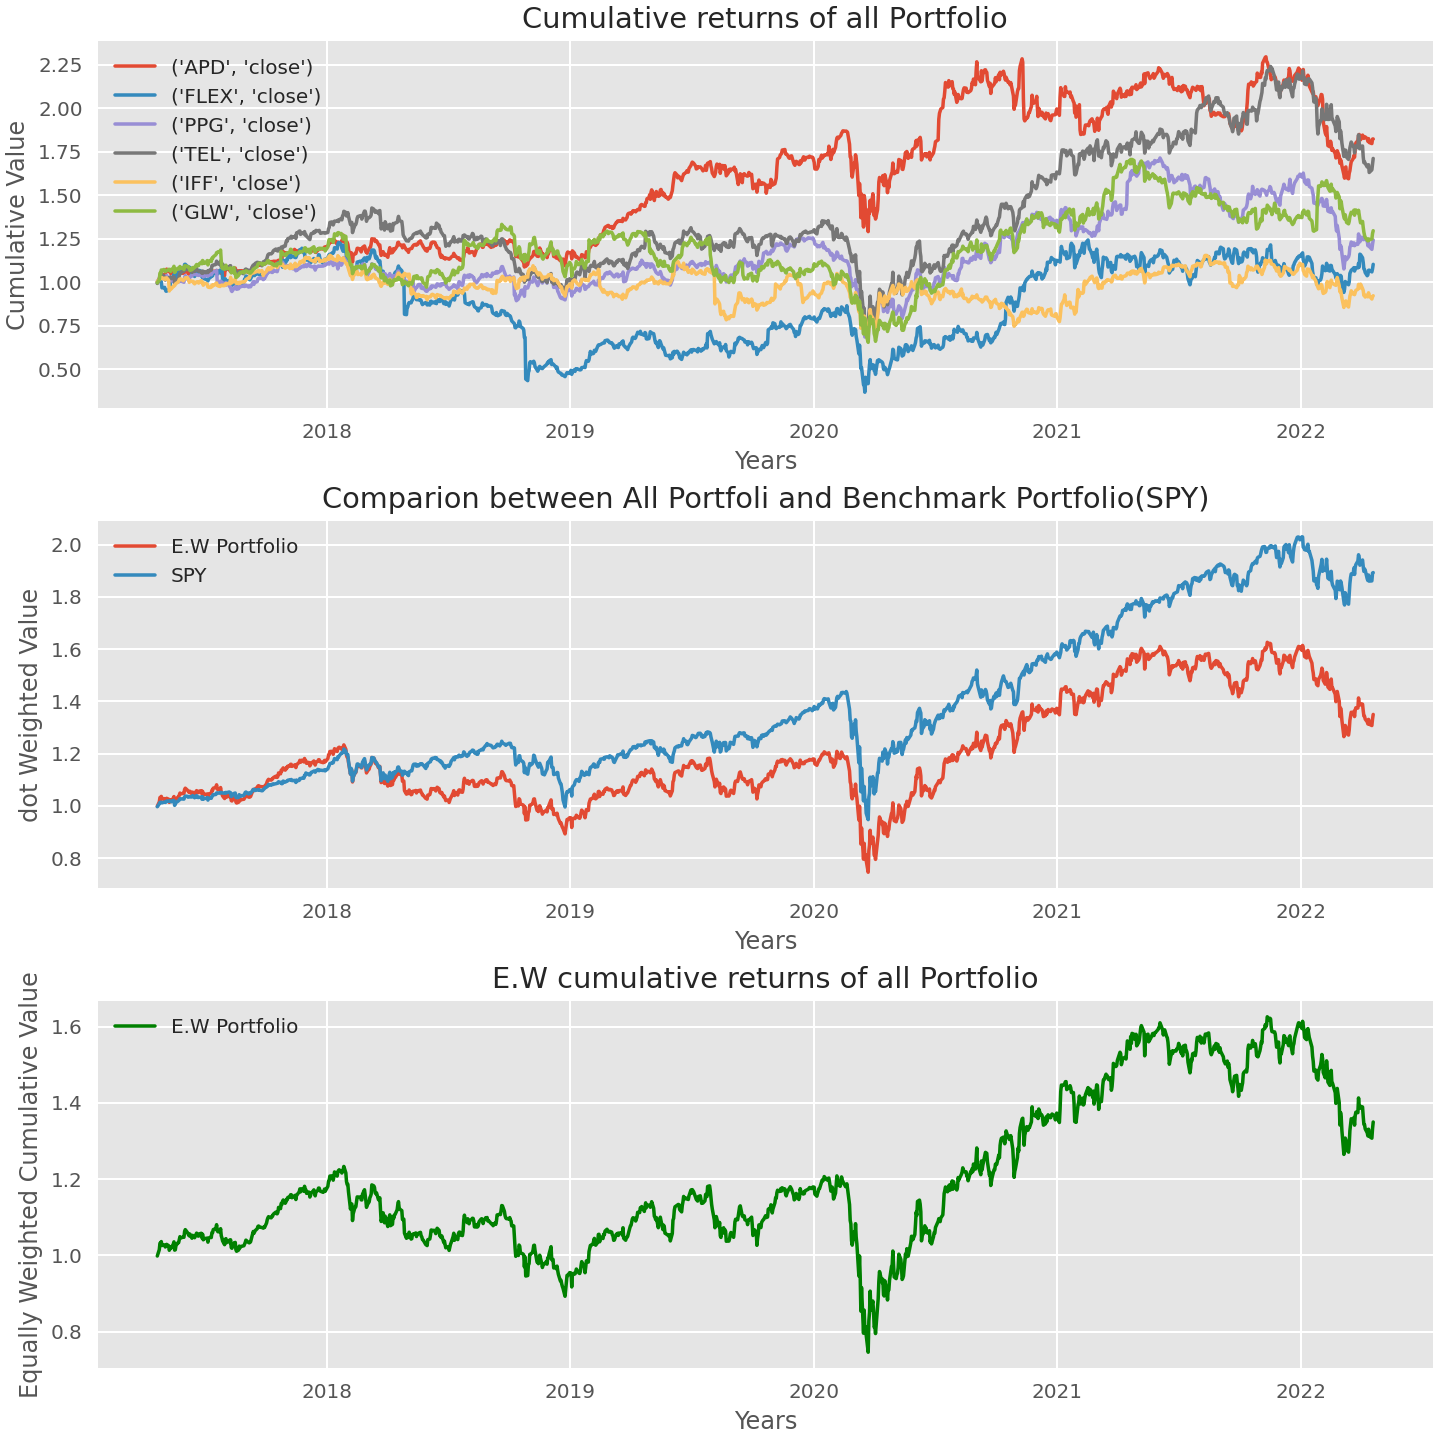

In [36]:

#Create the tabs
tab = pn.Tabs(
    ("Welcome", pn.Column(heading, text, width=600)),
              
    ("Monte Carlo simulation", 
     pn.Column("Choose your trading years", MC_layout)), 
    
    ("Confidence level", 
     pn.Column("Choose your initial investment amount", confidence_level_layout)), 
    
    ("Calculated Data", 
     pn.Column(df_1 + df_2 + df_3 + df_4)),

    ("Weighted Analysis", 
     pn.Column(top_returns_df, sharpe_ratio_df, benchmark_comaprison_df)),
    
    ("Graphs", pn.Column(graph_layout))
)             

#Display the tabs
tab

